<a href="https://github.com/thangckt/note_ml/blob/main/notebook/1_Practices/1_PT_Linear_Regression.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a> &nbsp;
<a href="https://colab.research.google.com/github/thangckt/note_ml/blob/main/notebook/1_Practices/1_PT_Linear_Regression.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Linear Regression

We will learn about linear regression. We will understand 
- the basic math behind it
- implement it just using NumPy, and then 
- implement it with [PyTorch](https://pytorch.org/)

Adapted from [this repo](https://github.com/ProtonX-AI/deep-learning-with-tensorflow-and-pytorch/blob/master/notebooks/07_Linear_Regression/07_PT_Linear_Regression.ipynb)

# Overview

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

* **Objective:**  Use inputs $X$ to predict the output $\hat{y}$ using a linear model. The model will be a line of best fit that minimizes the distance between the predicted (model's output) and target (ground truth) values. Training data $(X, y)$ is used to train the model and learn the weights $W$ using gradient descent.
* **Advantages:**
  * Computationally simple.
  * Highly interpretable.
  * Can account for continuous and categorical features.
* **Disadvantages:**
  * The model will perform well only when the data is linearly separable (for classification).
  * Usually not used for classification and only for regression.
* **Miscellaneous:** You can also use linear regression for binary classification tasks where if the predicted continuous value is above a threshold, it belongs to a certain class. But we will cover better techniques for classification in future lessons and will focus on linear regression for continuous regression tasks only.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('../light.mplstyle')

dir_nb = globals()['_dh'][0]

# Generate data

We're going to create some simple dummy data to apply linear regression on. It's going to create roughly linear data (`y = 3.5X + noise`); the random noise is added to create realistic data that doesn't perfectly align in a line. Our goal is to have the model converge to a similar linear equation (there will be slight variance since we added some noise).

In [3]:
# Generate synthetic data
def generate_data(num_samples):
    """Generate dummy data for linear regression."""
    X = np.array(range(num_samples))
    random_noise = np.random.uniform(-10,20,size=num_samples)
    y = 3.5*X + random_noise # add some noise
    return X, y

In [4]:
SEED = 1234
NUM_SAMPLES = 50

# Set seed for reproducibility
np.random.seed(SEED)

# Generate random (linear) data
X, y = generate_data(num_samples=NUM_SAMPLES)

In [5]:
# Load into a Pandas DataFrame
data = np.vstack([X, y]).T    # convert to comlums
df = pd.DataFrame(data, columns=['X', 'y'])
X = df[['X']].values
y = df[['y']].values
df.head()

,X,y
0,0.0,-4.254416
1,1.0,12.163263
2,2.0,10.131832
3,3.0,24.060758
4,4.0,27.399274


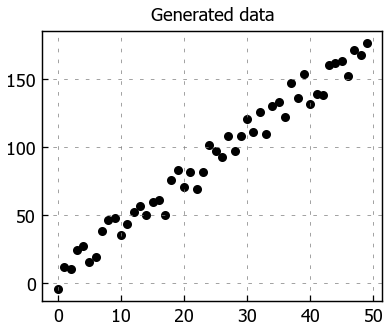

In [6]:
# Scatter plot
plt.title("Generated data")
plt.scatter(x=df['X'], y=df['y'])
plt.show()

# Implementation using just NumPy

Now that we have our data prepared, we'll first implement linear regression using just NumPy. This will let us really understand the underlying operations.

## Split data

Since our task is a regression task, we will randomly split our dataset into **three** sets: train, validation and test data splits.

* train: used to train our model.
* val : used to validate our model's performance during training.
* test: used to do an evaluation of our fully trained model.

In [7]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

# Shuffle data
if SHUFFLE:
    indices = list(range(NUM_SAMPLES))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

**NOTE**: Be careful not to shuffle X and y separately because then the inputs won't correspond to the outputs!

In [8]:
# Split indices
train_start = 0
train_end = int(0.7*NUM_SAMPLES)
val_start = train_end
val_end = int((TRAIN_SIZE+VAL_SIZE)*NUM_SAMPLES)
test_start = val_end

In [9]:
# Split data
X_train = X[train_start:train_end]
y_train = y[train_start:train_end]
X_val = X[val_start:val_end]
y_val = y[val_start:val_end]
X_test = X[test_start:]
y_test = y[test_start:]
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_test: (7, 1)
X_test: (8, 1), y_test: (8, 1)


## Standardize data

We need to standardize our data (zero mean and unit variance) or our models can optimize quickly when we are training.

$z = \frac{x_i - \mu}{\sigma}$
* $z$ = standardized value
* $x_i$ = inputs
* $\mu$ = mean
* $\sigma$ = standard deviation

In [10]:
def standardize_data(data, mean, std):
    return (data - mean)/std

In [11]:
# Determine means and stds
X_mean = np.mean(X_train)
X_std = np.std(X_train)
y_mean = np.mean(y_train)
y_std = np.std(y_train)

We need to treat the validation and test sets as if they were hidden datasets. So we only use the train set to determine the mean and std to avoid biasing our training process.

In [12]:
# Standardize
X_train = standardize_data(X_train, X_mean, X_std)
y_train = standardize_data(y_train, y_mean, y_std)
X_val = standardize_data(X_val, X_mean, X_std)
y_val = standardize_data(y_val, y_mean, y_std)
X_test = standardize_data(X_test, X_mean, X_std)
y_test = standardize_data(y_test, y_mean, y_std)

In [13]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train: mean: {np.mean(X_train, axis=0)[0]:.1f}, std: {np.std(X_train, axis=0)[0]:.1f}")
print (f"y_train: mean: {np.mean(y_train, axis=0)[0]:.1f}, std: {np.std(y_train, axis=0)[0]:.1f}")
print (f"X_val: mean: {np.mean(X_val, axis=0)[0]:.1f}, std: {np.std(X_val, axis=0)[0]:.1f}")
print (f"y_val: mean: {np.mean(y_val, axis=0)[0]:.1f}, std: {np.std(y_val, axis=0)[0]:.1f}")
print (f"X_test: mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"y_test: mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

X_train: mean: -0.0, std: 1.0
y_train: mean: 0.0, std: 1.0
X_val: mean: -0.5, std: 0.5
y_val: mean: -0.6, std: 0.5
X_test: mean: -0.6, std: 0.9
y_test: mean: -0.6, std: 0.9


## Weights

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

1. Randomly initialize the model's weights $W$.

In [14]:
INPUT_DIM = X_train.shape[1] # X is 1-dimensional
OUTPUT_DIM = y_train.shape[1] # y is 1-dimensional

# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, 1))
print (f"W: {W.shape}")
print (f"b: {b.shape}")

W: (1, 1)
b: (1, 1)


## Model

2. Feed inputs $X$ into the model to receive the predictions $\hat{y}$.
  * $\hat{y} = XW + b$

In [15]:
# Forward pass [NX1] · [1X1] = [NX1]
y_pred = np.dot(X_train, W) + b
print (f"y_pred: {y_pred.shape}")

y_pred: (35, 1)


## Loss
3. Compare the predictions $\hat{y}$ with the actual target values $y$ using the objective (cost) function to determine the loss $J$. A common objective function for linear regression is mean squared error (MSE). This function calculates the difference between the predicted and target values and squares it.

  * $J(\theta) = MSE = \frac{1}{N} \sum_{i-1}^{N} (y_i - \hat{y}_i)^2 $
    * ${y}$ = ground truth | $\in \mathbb{R}^{NX1}$
    * $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$

In [16]:
# Loss
N = len(y_train)
loss = (1/N) * np.sum((y_train - y_pred)**2)
print (f"loss: {loss:.2f}")

loss: 0.99


## Gradients
4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights.
  * $J(\theta) = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2  = \frac{1}{N}\sum_i (y_i - X_iW)^2 $
    * $\frac{\partial{J}}{\partial{W}} = -\frac{2}{N} \sum_i (y_i - X_iW) X_i = -\frac{2}{N} \sum_i (y_i - \hat{y}_i) X_i$
    * $\frac{\partial{J}}{\partial{b}} = -\frac{2}{N} \sum_i (y_i - X_iW)1 = -\frac{2}{N} \sum_i (y_i - \hat{y}_i)1$

In [17]:
# Backpropagation
dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
db = -(2/N) * np.sum((y_train - y_pred) * 1)

**NOTE**: The gradient is the derivative, or the rate of change of a function. It's a vector that points in the direction of greatest increase of a function. For example the gradient of our loss function ($J$) with respect to our weights ($W$) will tell us how to change W so we can maximize $J$. However, we want to minimize our loss so we subtract the gradient from $W$. 

## Update weights

5. Update the weights $W$ using a small learning rate $\alpha$.
  * $W = W - \alpha\frac{\partial{J}}{\partial{W}}$
  * $b = b - \alpha\frac{\partial{J}}{\partial{b}}$

In [18]:
LEARNING_RATE = 1e-1

# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

**NOTE**: The learning rate $\alpha$ is a way to control how much we update the weights by. If we choose a small learning rate, it may take a long time for our model to train. However, if we choose a large learning rate, we may overshoot and our training will never converge. The specific learning rate depends on our data and the type of models we use but it's typically good to explore in the range of $[1e^{-8}, 1e^{-1}]$. We'll explore learning rate update stratagies in later lessons.

## Training
6. Repeat steps 2 - 5 to minimize the loss and train the model.

In [19]:
NUM_EPOCHS = 100

# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, OUTPUT_DIM)
b = np.zeros((1, ))

# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX1] · [1X1] = [NX1]
    y_pred = np.dot(X_train, W) + b

    # Loss
    loss = (1/len(y_train)) * np.sum((y_train - y_pred)**2)

    # show progress
    if epoch_num%10 == 0:
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}")

    # Backpropagation
    dW = -(2/N) * np.sum((y_train - y_pred) * X_train)
    db = -(2/N) * np.sum((y_train - y_pred) * 1)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db

Epoch: 0, loss: 0.990
Epoch: 10, loss: 0.039
Epoch: 20, loss: 0.028
Epoch: 30, loss: 0.028
Epoch: 40, loss: 0.028
Epoch: 50, loss: 0.028
Epoch: 60, loss: 0.028
Epoch: 70, loss: 0.028
Epoch: 80, loss: 0.028
Epoch: 90, loss: 0.028


## Evaluation

In [20]:
# Predictions 
pred_train = W*X_train + b
pred_test = W*X_test + b

# MSE
train_mse = np.mean((y_train - pred_train) ** 2)
test_mse = np.mean((y_test - pred_test) ** 2)
print (f"train_MSE: {train_mse:.2f}, test_MSE: {test_mse:.2f}")

train_MSE: 0.03, test_MSE: 0.01


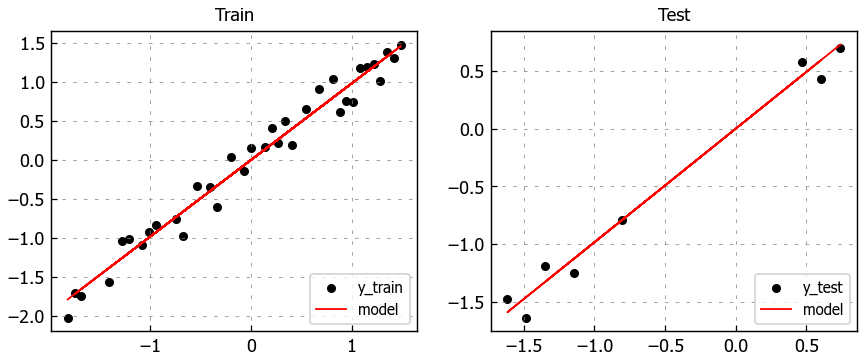

In [21]:
# Figure size
plt.figure(figsize=(8,3))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label='y_train')
plt.plot(X_train, pred_train, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test, color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

## Interpretability

Since we standardized our inputs and outputs, our weights were fit to those standardized values. So we need to unstandardize our weights so we can compare them to our true weight (3.5).

Note that both X and y were standardized.

$\hat{y}_{scaled} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}x_{{scaled}_j}$
* $y_{scaled} = \frac{\hat{y} - \bar{y}}{\sigma_y}$
* $x_{scaled} = \frac{x_j - \bar{x}_j}{\sigma_j}$

$\frac{\hat{y} - \bar{y}}{\sigma_y} = b_{scaled} + \sum_{j=1}^{k}W_{{scaled}_j}\frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y}_{scaled} = \frac{\hat{y}_{unscaled} - \bar{y}}{\sigma_y} = {b_{scaled}} + \sum_{j=1}^{k} {W}_{{scaled}_j} (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y}_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})\bar{x}_j + \sum_{j=1}^{k}{W}_{{scaled}_j}(\frac{\sigma_y}{\sigma_j})x_j $

In the expression above, we can see the expression $\hat{y}_{unscaled} = W_{unscaled}x + b_{unscaled} $ where

* $W_{unscaled} = \sum_{j=1}^{k}{W}_j(\frac{\sigma_y}{\sigma_j}) $

* $b_{unscaled} = b_{scaled}\sigma_y + \bar{y} - \sum_{j=1}^{k} {W}_j(\frac{\sigma_y}{\sigma_j})\bar{x}_j$

In [22]:
# Unscaled weights
W_unscaled = W * (y_std/X_std)
b_unscaled = b * y_std + y_mean - np.sum(W_unscaled*X_mean)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0][0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 7.8


# Implement using PyTorch
Now that we've implemented linear regression with Numpy, let's do the same with PyTorch. 

In [23]:
import torch

# Set seed for reproducibility
torch.manual_seed(SEED)

## Split data

When we're working with PyTorch we normally use the scikit learn's [splitting functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) to split our data.

In [30]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

The `train_val_test_split` function essentially splits our data twice. First, we separate out the test set. And then we separate the remaining other set into train and validation sets. 

In [31]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_test: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (35, 1), y_train: (35, 1)
X_val: (7, 1), y_test: (7, 1)
X_test: (8, 1), y_test: (8, 1)


## Standardize data

We can also use scikit learn to do [preprocessing and normalization](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing). 

In [32]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [33]:
# Apply scaler on training and test data
X_train = X_scaler.transform(X_train)
y_train = y_scaler.transform(y_train).ravel().reshape(-1, 1)
X_val = X_scaler.transform(X_val)
y_val = y_scaler.transform(y_val).ravel().reshape(-1, 1)
X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test).ravel().reshape(-1, 1)

In [34]:
# Check (means should be ~0 and std should be ~1)
print (f"X_train: mean: {np.mean(X_train, axis=0)[0]:.1f}, std: {np.std(X_train, axis=0)[0]:.1f}")
print (f"y_train: mean: {np.mean(y_train, axis=0)[0]:.1f}, std: {np.std(y_train, axis=0)[0]:.1f}")
print (f"X_val: mean: {np.mean(X_val, axis=0)[0]:.1f}, std: {np.std(X_val, axis=0)[0]:.1f}")
print (f"y_val: mean: {np.mean(y_val, axis=0)[0]:.1f}, std: {np.std(y_val, axis=0)[0]:.1f}")
print (f"X_test: mean: {np.mean(X_test, axis=0)[0]:.1f}, std: {np.std(X_test, axis=0)[0]:.1f}")
print (f"y_test: mean: {np.mean(y_test, axis=0)[0]:.1f}, std: {np.std(y_test, axis=0)[0]:.1f}")

X_train: mean: -0.0, std: 1.0
y_train: mean: 0.0, std: 1.0
X_val: mean: 0.1, std: 0.6
y_val: mean: 0.1, std: 0.7
X_test: mean: -0.3, std: 0.7
y_test: mean: -0.3, std: 0.6


## Weights

We will be using [Linear layers](https://pytorch.org/docs/stable/nn.html#linear-layers) in our MLP implementation. These layers will act as out weights (and biases).

$ z = XW $ 

In [37]:
from torch import nn

# Inputs
N = 3 # num samples
x = torch.randn(N, INPUT_DIM)
print (x.shape)
print (x.numpy())

torch.Size([3, 1])
[[ 0.21673824]
 [-0.6122731 ]
 [ 0.50361073]]


In [38]:
# Weights
m = nn.Linear(INPUT_DIM, OUTPUT_DIM)
print (m)
print (f"weights ({m.weight.shape}): {m.weight[0][0]}")
print (f"bias ({m.bias.shape}): {m.bias[0]}")

Linear(in_features=1, out_features=1, bias=True)
weights (torch.Size([1, 1])): 0.5497009754180908
bias (torch.Size([1])): 0.6416051387786865


In [39]:
# Forward pass
z = m(x) 
print (z.shape)
print (z.detach().numpy())

torch.Size([3, 1])
[[0.76074636]
 [0.30503803]
 [0.91844046]]


## Model

Our goal is to learn a linear model $\hat{y}$ that models $y$ given $X$. 

$\hat{y} = XW + b$
* $\hat{y}$ = predictions | $\in \mathbb{R}^{NX1}$ ($N$ is the number of samples)
* $X$ = inputs | $\in \mathbb{R}^{NXD}$ ($D$ is the number of features)
* $W$ = weights | $\in \mathbb{R}^{DX1}$ 
* $b$ = bias | $\in \mathbb{R}^{1}$ 

In [42]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        
    def forward(self, x_in):
        y_pred = self.fc1(x_in)
        return y_pred

In [45]:
from torchsummary import summary

# Initialize model
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
print (model.named_parameters)
summary(model, input_size=(INPUT_DIM,)) # -1 is the batch size

<bound method Module.named_parameters of LinearRegression(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Loss

In [46]:
loss_fn = nn.MSELoss()
y_pred = torch.Tensor([0., 0., 1., 1.])
y_true =  torch.Tensor([1., 1., 1., 0.])
loss = loss_fn(y_pred, y_true)
print('Loss: ', loss.numpy())

Loss:  0.75


## Optimizer

When we implemented linear regression with just NumPy, we used batch gradient descent to update our weights. But there are actually many different [gradient descent optimization algorithms](https://ruder.io/optimizing-gradient-descent/) to choose from and it depends on the situation. However, the [ADAM optimizer](https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms/#adam) has become a standard algorithm for most cases. 

In [47]:
from torch.optim import Adam

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 

## Training

In [48]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [49]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0: 
        print (f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 2.14
Epoch: 20 | loss: 0.06
Epoch: 40 | loss: 0.02
Epoch: 60 | loss: 0.02
Epoch: 80 | loss: 0.02


## Evaluation

In [50]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [51]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f'train_error: {train_error:.2f}')
print(f'test_error: {test_error:.2f}')

train_error: 0.02
test_error: 0.01


Since we only have one feature, it's easy to visually inspect the model.

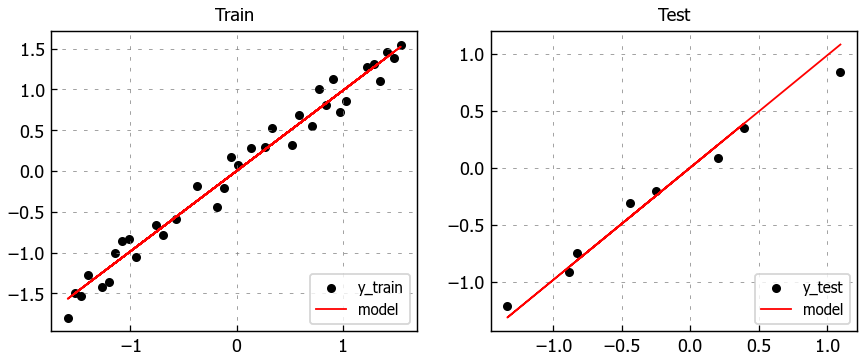

In [52]:
# Figure size
plt.figure(figsize=(8,3))

# Plot train data
plt.subplot(1, 2, 1)
plt.title("Train")
plt.scatter(X_train, y_train, label='y_train')
plt.plot(X_train, pred_train.detach().numpy(), color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test")
plt.scatter(X_test, y_test, label='y_test')
plt.plot(X_test, pred_test.detach().numpy(), color='red', linewidth=1, linestyle='-', label='model')
plt.legend(loc='lower right')

# Show plots
plt.show()

## Inference

After training a model, we can use it to predict on new data.

In [53]:
# Feed in your own inputs
sample_indices = [10, 15, 25]
X_infer = np.array(sample_indices, dtype=np.float32)
X_infer = torch.Tensor(X_scaler.transform(X_infer.reshape(-1, 1)))

Recall that we need to unstandardize our predictions.

$ \hat{y}_{scaled} = \frac{\hat{y} - \mu_{\hat{y}}}{\sigma_{\hat{y}}} $

$ \hat{y} = \hat{y}_{scaled} * \sigma_{\hat{y}} + \mu_{\hat{y}} $

In [54]:
# Unstandardize predictions
pred_infer = model(X_infer).detach().numpy() * np.sqrt(y_scaler.var_) + y_scaler.mean_
for i, index in enumerate(sample_indices):
    print (f"{df.iloc[index]['y']:.2f} (actual) → {pred_infer[i][0]:.2f} (predicted)")

35.73 (actual) → 42.24 (predicted)
59.34 (actual) → 59.28 (predicted)
97.04 (actual) → 93.36 (predicted)


## Interpretability

Linear regression offers the great advantage of being highly interpretable. Each feature has a coefficient which signifies its importance/impact on the output variable y. We can interpret our coefficient as follows: by increasing X by 1 unit, we increase y by $W$ (~3.65) units. 

In [55]:
# Unstandardize coefficients 
W = model.fc1.weight.data.numpy()[0][0]
b = model.fc1.bias.data.numpy()[0]
W_unscaled = W * (y_scaler.scale_/X_scaler.scale_)
b_unscaled = b * y_scaler.scale_ + y_scaler.mean_ - np.sum(W_unscaled*X_scaler.mean_)
print ("[actual] y = 3.5X + noise")
print (f"[model] y_hat = {W_unscaled[0]:.1f}X + {b_unscaled[0]:.1f}") 

[actual] y = 3.5X + noise
[model] y_hat = 3.4X + 8.2


# Regularization

Regularization helps decrease overfitting. Below is L2 regularization (ridge regression). There are many forms of regularization but they all work to reduce overfitting in our models. With L2 regularization, we are penalizing the weights with large magnitudes by decaying them. Having certain weights with high magnitudes will lead to preferential bias with the inputs and we want the model to work with all the inputs and not just a select few. There are also other types of regularization like L1 (lasso regression) which is useful for creating sparse models where some feature cofficients are zeroed out, or elastic which combines L1 and L2 penalties. 

**Note**: Regularization is not just for linear regression. You can use it to regularize any model's weights including the ones we will look at in future lessons.

$ J(\theta) = = \frac{1}{2}\sum_{i}(X_iW - y_i)^2 + \frac{\lambda}{2}W^TW$

$ \frac{\partial{J}}{\partial{W}}  = X (\hat{y} - y) + \lambda W $

$W = W- \alpha\frac{\partial{J}}{\partial{W}}$
* $\lambda$ is the regularzation coefficient

In PyTorch, we can add L2 regularization by adjusting our optimizer. The [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) optimizer has a `weight_decay` paramter which to control the L2 penalty.

In [ ]:
L2_LAMBDA = 1e-2

In [ ]:
# Initialize model
model = LinearRegression(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)

In [ ]:
# Optimizer (w/ L2 regularization)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 

In [ ]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%20==0: 
        print (f"Epoch: {epoch} | loss: {loss:.2f}")

Epoch: 0 | loss: 2.20
Epoch: 20 | loss: 0.06
Epoch: 40 | loss: 0.03
Epoch: 60 | loss: 0.02
Epoch: 80 | loss: 0.02


In [ ]:
# Predictions
pred_train = model(X_train)
pred_test = model(X_test)

In [ ]:
# Performance
train_error = loss_fn(pred_train, y_train)
test_error = loss_fn(pred_test, y_test)
print(f'train_error: {train_error:.2f}')
print(f'test_error: {test_error:.2f}')

train_error: 0.02
test_error: 0.01


Regularization didn't make a difference in performance with this specific example because our data is generated from a perfect linear equation but for large realistic data, regularization can help our model generalize well.

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             